<a href="https://colab.research.google.com/github/ZhiyuanH3/BadmintonDataAnalysis/blob/master/Badminton_data_analysis0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We start by mounting the google drive, in which the dataset is stored.

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

The pandas package is imported. 

In [0]:
df = pd.read_csv('/content/drive/My Drive/Dataset/BWF/momota/Momota_dataset.csv')

In [0]:
#df.Player1.unique()

Here the csv file is converted into a pandas DataFrame object, which is basically a table as can be seen below: 

In [0]:
df.head(4)

,Unnamed: 0,Tournament,Time,Place,Player1,Player2,Score,Duration,Stats_href
0,0,PERODUA Malaysia Masters 2020,Wed 1/8/2020,"Badminton World Federation | Kuala Lumpur, Mal...",[JPN] Kento MOMOTA,Kashyap PARUPALLI[IND],"['21-17', '21-16']",0:43,./match.aspx?id=6D74F318-A951-4C8F-9451-5DA3F3...
1,1,PERODUA Malaysia Masters 2020,Thu 1/9/2020,"Badminton World Federation | Kuala Lumpur, Mal...",[JPN] Kento MOMOTA,H. S. PRANNOY[IND],"['21-14', '21-16']",0:45,./match.aspx?id=6D74F318-A951-4C8F-9451-5DA3F3...
2,2,PERODUA Malaysia Masters 2020,Fri 1/10/2020,"Badminton World Federation | Kuala Lumpur, Mal...",[JPN] Kento MOMOTA,Yu Xiang HUANG[CHN],"['21-13', '19-21', '21-9']",1:07,./match.aspx?id=6D74F318-A951-4C8F-9451-5DA3F3...
3,0,HSBC BWF World Tour Finals 2019,Wed 12/11/2019,"Badminton World Federation | Guangzhou, China",[JPN] Kento Momota,Tzu Wei Wang[TPE],"['21-10', '21-9']",0:29,./match.aspx?id=EF144033-A23C-47A2-9CC7-4F2922...


As we can see, the table shows the match events played by the japanese badminton player Kento Momota registrated in the BWF official website. The basic information of each event are displaced as varies columns, such as the name of the corresponding tournament, the date the event took place, location of the court, the players & their nationalities, the score and the duration of the match. The 'Stats_href' column stores the links of the matches, which are not needed in this analysis.

In [0]:
df.shape

(390, 9)

The table has 390 rows and 9 columns, meaning that we have 390 events in total. The csb file was scraped from the BWF website, which means matches played by Momota, which are not registrated by the BWF federation, are not included in this table. 
Even though the table is not big, is't good practice to do some preliminary data cleaning. The 'Unnamed: 0' and 'Stats_href' can be dropped here, since they don't contribute any interesting info. 
Since we are doing an analysis of one specific player (Kento Momota), it's known that one of the player is Momota.
Let's convert the 'Player1', 'Player2' into 'opponent' and 'isPlayer1', where 'isPlayer1' indicates if Momota is the 'Player1' in the match.

In [0]:
df.drop(['Unnamed: 0', 'Stats_href'], axis=1, inplace=True)

In [0]:
df.head(4)

,Tournament,Time,Place,Player1,Player2,Score,Duration
0,PERODUA Malaysia Masters 2020,Wed 1/8/2020,"Badminton World Federation | Kuala Lumpur, Mal...",[JPN] Kento MOMOTA,Kashyap PARUPALLI[IND],"['21-17', '21-16']",0:43
1,PERODUA Malaysia Masters 2020,Thu 1/9/2020,"Badminton World Federation | Kuala Lumpur, Mal...",[JPN] Kento MOMOTA,H. S. PRANNOY[IND],"['21-14', '21-16']",0:45
2,PERODUA Malaysia Masters 2020,Fri 1/10/2020,"Badminton World Federation | Kuala Lumpur, Mal...",[JPN] Kento MOMOTA,Yu Xiang HUANG[CHN],"['21-13', '19-21', '21-9']",1:07
3,HSBC BWF World Tour Finals 2019,Wed 12/11/2019,"Badminton World Federation | Guangzhou, China",[JPN] Kento Momota,Tzu Wei Wang[TPE],"['21-10', '21-9']",0:29


One thing one can do to the Time column is to extract the date, month, year and the weekday (perhaps even the week number later) info.
Let's first write a function to split the Time column.

In [0]:
def timeSplit(row):
  time = row['Time']
  weekday_date = time.split(' ')
  weekday = weekday_date[0]
  try:
    month, day, year = weekday_date[1].split('/')
    return weekday, month, day, year
  except:
    # For events, which have no Time info (or with false Time format), '?'s are assigned to the output columns
    return ['?'] * 4 

In [0]:
df['weekday'] = df.apply(timeSplit, axis=1)

In [0]:
df[['weekday', 'month', 'day', 'year']] = pd.DataFrame(df.weekday.values.tolist())

In [0]:
df.drop('Time', axis=1, inplace=True)

In [0]:
df.head(4)

,Tournament,Place,Player1,Player2,Score,Duration,weekday,month,day,year
0,PERODUA Malaysia Masters 2020,"Badminton World Federation | Kuala Lumpur, Mal...",[JPN] Kento MOMOTA,Kashyap PARUPALLI[IND],"['21-17', '21-16']",0:43,Wed,1,8,2020
1,PERODUA Malaysia Masters 2020,"Badminton World Federation | Kuala Lumpur, Mal...",[JPN] Kento MOMOTA,H. S. PRANNOY[IND],"['21-14', '21-16']",0:45,Thu,1,9,2020
2,PERODUA Malaysia Masters 2020,"Badminton World Federation | Kuala Lumpur, Mal...",[JPN] Kento MOMOTA,Yu Xiang HUANG[CHN],"['21-13', '19-21', '21-9']",1:07,Fri,1,10,2020
3,HSBC BWF World Tour Finals 2019,"Badminton World Federation | Guangzhou, China",[JPN] Kento Momota,Tzu Wei Wang[TPE],"['21-10', '21-9']",0:29,Wed,12,11,2019


Let's see how many events are not registrated with Time:

In [0]:
print('Number of events with NaN "year": ', df.year.isnull().sum())
print('Number of events with ? "year": ', (df.year == '?').sum())

Number of events with NaN "year":  0
Number of events with ? "year":  40


One thing we can do to recover the year info is to extract them from the 'Tournament' column:

In [0]:
#df.Tournament.apply(lambda tour: tour[-4:])

In [0]:
df.loc[:, 'year'][df.year == '?'] = df[df.year == '?'].Tournament.apply(lambda tour: tour[-4:])

In [0]:
df.Place.unique()

array(['Badminton World Federation | Kuala Lumpur, Malaysia',
       'Badminton World Federation | Guangzhou, China',
       'Badminton World Federation | Fuzhou, China',
       'Badminton World Federation | PARIS, France',
       'Badminton World Federation | Odense V, Denmark',
       'Badminton World Federation | Incheon, Korea',
       'Badminton World Federation | Changzhou, China',
       'Badminton World Federation | Basel, Switzerland',
       'Badminton World Federation | Tokyo, Japan',
       'Badminton World Federation | Jakarta, Indonesia',
       'Badminton World Federation | Nanning, China',
       'Badminton World Federation | Wuhan, China',
       'Badminton World Federation | Singapore, Singapore',
       'Badminton World Federation | Birmingham, Great Britain',
       'Badminton World Federation | Muelheim an der Ruhr, Germany',
       'Badminton World Federation | Kowloon, Hong Kong China',
       'Badminton World Federation | Paris, France',
       'Badminton World 

We can see the 'Place' column always contain a prefix, such as 'Badminton World Federation |', which is somewhat redundant. Let's drop this prefix and split the column into city and country columns by taking advantage of the format 'to be dropped | city, country'.

In [0]:
def locationSplit(row):
  location = row['Place']
  _, city_country = location.split('| ')
  # One inconsistency spotted here, let's fix it
  if city_country == 'Guadalajara':
    city_country = 'Guadalajara, Mexico'
  # Several typos spotted (extra ','s):
  if city_country.count(',') > 1:
    # Remove additional ','
    for i in range(city_country.count(',') - 1):
      city_country = city_country.replace(',', '', 1) 

  return city_country.split(',')

In [0]:
df['location'] = df.apply(locationSplit, axis=1)

In [0]:
df[['city', 'country']] = pd.DataFrame(df.location.tolist())

Let's check again if there're typos in countris:

In [0]:
df.country.unique()

array([' Malaysia', ' China', ' France', ' Denmark', ' Korea',
       ' Switzerland', ' Japan', ' Indonesia', ' Singapore',
       ' Great Britain', ' Germany', ' Hong Kong China', ' Thailand',
       ' Macau China', ' Netherlands', ' Czech Republic', ' Belgium',
       ' U.S.A.', ' Canada', ' India', ' England',
       ' United Arab Emirates', ' Australia', ' Chinese Taipei',
       ' Austria', ' Sweden', ' Mexico'], dtype=object)

And the same check for cities:

In [0]:
df.city.unique()

array(['Kuala Lumpur', 'Guangzhou', 'Fuzhou', 'PARIS', 'Odense V',
       'Incheon', 'Changzhou', 'Basel', 'Tokyo', 'Jakarta', 'Nanning',
       'Wuhan', 'Singapore', 'Birmingham', 'Muelheim an der Ruhr',
       'Kowloon', 'Paris', 'Odense', 'Seoul', 'Nanjing', 'Bukit Jalil',
       'Bangkok', 'Mülheim an der Ruhr', 'Alor Setar', 'Macau', 'Almere',
       'Brno', 'Leuven', 'Orange County', 'Calagry', 'Shah Alam',
       'New Delhi', 'Hyderabad', 'Dubai', 'Sydney', 'Dongguan',
       'Singapore City', ' Dubai ', 'Copenhagen ', ' Birmingham',
       ' Kuala Lumpur', ' Seoul', 'Macau City ', 'Hong Kong', 'SHANGHAI',
       ' Changzhou ', 'Orange', 'Singapore ', 'Taipei', 'Wien',
       'Stockholm', 'Macau ', 'Shanghai ', 'Chiba ', 'Chiba', 'Palembang',
       'Richmond ', 'Johor Bahru', 'Qingdao', 'Macao', 'Lucknow',
       'LUCKNOW', 'Vienna', 'Guadalajara'], dtype=object)

As we can see, 'Birmingham' appeared twice, since additional space is attached to the string. The same mistake happened to 'Seoul' and 'Chiba'. This is also the case for 'Macau' and there's a typo 'Macao'. 'Lucknow' appeared twice as well (the second time as 'LUCKNOW'). The same happened to 'Shanghai' and 'Paris'. 
'Odense V' -> 'Odense';
'Singapore' -> 'Singapore City';
'Orange County' -> 'Orange';



Let's start by stripping the spaces, followed by a lower case conversion.
Then we can fix the remaining typos by mapping.

In [0]:
def typoFix(row):
  city = row['city']

  # Remove spaces from start and end of strings
  while city[0] == ' ':
    city = city[1:]

  while city[-1] == ' ':
    city = city[:-1]

  # Lower case conversion 
  city = city.lower()

  if city == 'orange':
    city = 'orange county'
  elif city == 'singapore city':
    city = 'singapore'
  elif city == 'odense':
    city = 'odense v'
  elif city == 'macao' or city == 'macau city':
    city = 'macau'

  return city

In [0]:
df.city = df.apply(typoFix, axis=1)

In [0]:
df.city.unique()

array(['kuala lumpur', 'guangzhou', 'fuzhou', 'paris', 'odense v',
       'incheon', 'changzhou', 'basel', 'tokyo', 'jakarta', 'nanning',
       'wuhan', 'singapore', 'birmingham', 'muelheim an der ruhr',
       'kowloon', 'seoul', 'nanjing', 'bukit jalil', 'bangkok',
       'mülheim an der ruhr', 'alor setar', 'macau', 'almere', 'brno',
       'leuven', 'orange county', 'calagry', 'shah alam', 'new delhi',
       'hyderabad', 'dubai', 'sydney', 'dongguan', 'copenhagen',
       'hong kong', 'shanghai', 'taipei', 'wien', 'stockholm', 'chiba',
       'palembang', 'richmond', 'johor bahru', 'qingdao', 'lucknow',
       'vienna', 'guadalajara'], dtype=object)

In [0]:
df.drop(['Place','location'], axis=1, inplace=True)

In [0]:
df.head(4)

,Tournament,Player1,Player2,Score,Duration,weekday,month,day,year,city,country
0,PERODUA Malaysia Masters 2020,[JPN] Kento MOMOTA,Kashyap PARUPALLI[IND],"['21-17', '21-16']",0:43,Wed,1,8,2020,kuala lumpur,Malaysia
1,PERODUA Malaysia Masters 2020,[JPN] Kento MOMOTA,H. S. PRANNOY[IND],"['21-14', '21-16']",0:45,Thu,1,9,2020,kuala lumpur,Malaysia
2,PERODUA Malaysia Masters 2020,[JPN] Kento MOMOTA,Yu Xiang HUANG[CHN],"['21-13', '19-21', '21-9']",1:07,Fri,1,10,2020,kuala lumpur,Malaysia
3,HSBC BWF World Tour Finals 2019,[JPN] Kento Momota,Tzu Wei Wang[TPE],"['21-10', '21-9']",0:29,Wed,12,11,2019,guangzhou,China


The 'Player1', 'Player2' columns include the players' nationality.
Let's extract this into a new column.

In [0]:
def getNationP1(row):
  player_nation = row 
  nation, player = player_nation.split(']')
  nation = nation.replace('[', '')
  return player.upper(), nation.upper()

def getNationP2(row):
  player_nation = row 
  player, nation = player_nation.split('[')
  nation = nation.replace(']', '') 
  return player.upper(), nation.upper()

In [0]:
df['Player1'] = df.Player1.apply(getNationP1)
df['Player2'] = df.Player2.apply(getNationP2)

In [0]:
df[['player1','nationalityP1']] = pd.DataFrame(df.Player1.tolist())
df[['player2','nationalityP2']] = pd.DataFrame(df.Player2.tolist())

In [0]:
df.drop(['Player1', 'Player2'], axis=1, inplace=True)

In [0]:
df.head(4)

,Tournament,Score,Duration,weekday,month,day,year,city,country,player1,nationalityP1,player2,nationalityP2
0,PERODUA Malaysia Masters 2020,"['21-17', '21-16']",0:43,Wed,1,8,2020,kuala lumpur,Malaysia,KENTO MOMOTA,JPN,KASHYAP PARUPALLI,IND
1,PERODUA Malaysia Masters 2020,"['21-14', '21-16']",0:45,Thu,1,9,2020,kuala lumpur,Malaysia,KENTO MOMOTA,JPN,H. S. PRANNOY,IND
2,PERODUA Malaysia Masters 2020,"['21-13', '19-21', '21-9']",1:07,Fri,1,10,2020,kuala lumpur,Malaysia,KENTO MOMOTA,JPN,YU XIANG HUANG,CHN
3,HSBC BWF World Tour Finals 2019,"['21-10', '21-9']",0:29,Wed,12,11,2019,guangzhou,China,KENTO MOMOTA,JPN,TZU WEI WANG,TPE


Now we can add the 'isPlayer1' column mentioned above:

In [0]:
def getOpponent(row):
  if row['isPlayer1']:
    return row['player2'], row['nationalityP2']
  else:
    return row['player1'], row['nationalityP1']

In [0]:
df['isPlayer1'] = df.player1.apply(lambda p1: ('KENTO'in p1) and ('MOMOTA' in p1))

In [0]:
df['opponent_nationality'] = df.apply(getOpponent, axis=1)
df[['opponent', 'nationality']] = pd.DataFrame(df.opponent_nationality.tolist())
df.drop(['player1', 'player2', 'nationalityP1', 'nationalityP2', 'opponent_nationality'], axis=1, inplace=True)

In [0]:
df.head(4)

,Tournament,Score,Duration,weekday,month,day,year,city,country,isPlayer1,opponent,nationality
0,PERODUA Malaysia Masters 2020,"['21-17', '21-16']",0:43,Wed,1,8,2020,kuala lumpur,Malaysia,True,KASHYAP PARUPALLI,IND
1,PERODUA Malaysia Masters 2020,"['21-14', '21-16']",0:45,Thu,1,9,2020,kuala lumpur,Malaysia,True,H. S. PRANNOY,IND
2,PERODUA Malaysia Masters 2020,"['21-13', '19-21', '21-9']",1:07,Fri,1,10,2020,kuala lumpur,Malaysia,True,YU XIANG HUANG,CHN
3,HSBC BWF World Tour Finals 2019,"['21-10', '21-9']",0:29,Wed,12,11,2019,guangzhou,China,True,TZU WEI WANG,TPE


Now we can focus on the Score column. A badminton match is won by the player, who wins two out of the three games. As shown by the table, there're either two or three elements in a score list and the value on the lefthand side of the '-' displays the score of player1 in a game. Let's try to transform this into three columns.
It looks as if the values of the 'Score' column are lists. In fact, they are just a string (with '[' and ']' at the beginning and in the end).
Let's write a function to convert this into actual strings.

In [0]:
def getScore(row):
  score = row['Score']

  score = score.replace(' ', '')
  score = score.replace('[', '')
  score = score.replace(']', '')
  score = score.replace("'", "")

  score = score.split(',')

  while len(score) < 3:
    score.append('?')
  return score  

In [0]:
df['score'] = df.apply(getScore, axis=1)

In [0]:
df[['game1','game2','game3']] = pd.DataFrame(df.score.tolist())

In [0]:
df.drop(['score', 'Score'], axis=1, inplace=True)

In [0]:
df.head(4)

,Tournament,Duration,weekday,month,day,year,city,country,isPlayer1,opponent,nationality,game1,game2,game3
0,PERODUA Malaysia Masters 2020,0:43,Wed,1,8,2020,kuala lumpur,Malaysia,True,KASHYAP PARUPALLI,IND,21-17,21-16,?
1,PERODUA Malaysia Masters 2020,0:45,Thu,1,9,2020,kuala lumpur,Malaysia,True,H. S. PRANNOY,IND,21-14,21-16,?
2,PERODUA Malaysia Masters 2020,1:07,Fri,1,10,2020,kuala lumpur,Malaysia,True,YU XIANG HUANG,CHN,21-13,19-21,21-9
3,HSBC BWF World Tour Finals 2019,0:29,Wed,12,11,2019,guangzhou,China,True,TZU WEI WANG,TPE,21-10,21-9,?


In [0]:
df.game1.unique()

array(['21-17', '21-14', '21-13', '21-10', '19-21', '17-21', '21-9',
       '21-18', '21-19', '21-15', '15-21', '10-21', '21-6', '21-12',
       '21-11', '21-16', '22-20', '16-21', '18-21', '12-21', '20-22',
       '24-26', '14-21', '22-24', '13-21', '9-21', '23-21', '21-8',
       '8-21', '11-21', '21-5', '21-7', '7-21', '6-21', '25-23', '24-22',
       'Walkover', '21-23'], dtype=object)

In [0]:
df.game3.unique()

array(['?', '21-9', '21-15', '21-14', '21-16', '21-18', '21-4', '21-13',
       '21-19', '18-21', '21-11', '21-8', '22-20', '16-21', '20-22',
       '19-21', '21-17', '15-21', '8-21', '14-21', '12-21', '21-10',
       '13-21', '17-21', '21-7', '21-12', '9-21', '6-21', '21-6', '23-21',
       '21-5'], dtype=object)

Now that we have the scores of the three game in a match, let's further split the columns into scores for player1 and player2.

In [0]:
def scoreSplit(row):
  if row in ['Walkover', '?']:
    return np.nan, np.nan #'?', '?'
  else:  
    s1_s2 = row
    s1, s2 = s1_s2.split('-')
    return int(s1), int(s2)

In [0]:
df['g1'] = df.game1.apply(scoreSplit)
df['g2'] = df.game2.apply(scoreSplit)
df['g3'] = df.game3.apply(scoreSplit)

In [0]:
df[['gm1_plr1', 'gm1_plr2']] = pd.DataFrame(df.g1.tolist())
df[['gm2_plr1', 'gm2_plr2']] = pd.DataFrame(df.g2.tolist())
df[['gm3_plr1', 'gm3_plr2']] = pd.DataFrame(df.g3.tolist())

In [0]:
df.drop(['game1','game2','game3','g1','g2','g3'], axis=1, inplace=True)

In [0]:
df.head(4)

,Tournament,Duration,weekday,month,day,year,city,country,isPlayer1,opponent,nationality,gm1_plr1,gm1_plr2,gm2_plr1,gm2_plr2,gm3_plr1,gm3_plr2
0,PERODUA Malaysia Masters 2020,0:43,Wed,1,8,2020,kuala lumpur,Malaysia,True,KASHYAP PARUPALLI,IND,21.0,17.0,21.0,16.0,NaN,NaN
1,PERODUA Malaysia Masters 2020,0:45,Thu,1,9,2020,kuala lumpur,Malaysia,True,H. S. PRANNOY,IND,21.0,14.0,21.0,16.0,NaN,NaN
2,PERODUA Malaysia Masters 2020,1:07,Fri,1,10,2020,kuala lumpur,Malaysia,True,YU XIANG HUANG,CHN,21.0,13.0,19.0,21.0,21.0,9.0
3,HSBC BWF World Tour Finals 2019,0:29,Wed,12,11,2019,guangzhou,China,True,TZU WEI WANG,TPE,21.0,10.0,21.0,9.0,NaN,NaN


In this analysis we'll discard the matches, which have no registrated scores (including walkovers):

In [0]:
df = df[ ~df.gm1_plr1.isnull() ]

Now we count if a two game match was played for each event:

In [0]:
df['in2Games'] = df.gm3_plr1.apply(lambda x: pd.isnull(x))

In [0]:
def getMinutes(duration):
  duration = duration.replace(' ', '')
  hours, minutes = duration.split(':')
  return int(hours)*60 + int(minutes)

The 'Duration' column has the format: 'hour:minute' 
We can convert this into total minutes:

In [0]:
df.Duration = df.Duration.apply(getMinutes)

In [0]:
df

,Tournament,Duration,weekday,month,day,year,city,country,isPlayer1,opponent,nationality,gm1_plr1,gm1_plr2,gm2_plr1,gm2_plr2,gm3_plr1,gm3_plr2,in2Games
0,PERODUA Malaysia Masters 2020,43,Wed,1,8,2020,kuala lumpur,Malaysia,True,KASHYAP PARUPALLI,IND,21.0,17.0,21.0,16.0,NaN,NaN,True
1,PERODUA Malaysia Masters 2020,45,Thu,1,9,2020,kuala lumpur,Malaysia,True,H. S. PRANNOY,IND,21.0,14.0,21.0,16.0,NaN,NaN,True
2,PERODUA Malaysia Masters 2020,67,Fri,1,10,2020,kuala lumpur,Malaysia,True,YU XIANG HUANG,CHN,21.0,13.0,19.0,21.0,21.0,9.0,False
3,HSBC BWF World Tour Finals 2019,29,Wed,12,11,2019,guangzhou,China,True,TZU WEI WANG,TPE,21.0,10.0,21.0,9.0,NaN,NaN,True
4,HSBC BWF World Tour Finals 2019,83,Thu,12,12,2019,guangzhou,China,True,ANDERS ANTONSEN,DEN,19.0,21.0,21.0,15.0,21.0,15.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,BWF World Junior Championships 2010,25,?,?,?,2010,guadalajara,Mexico,True,VILSON VATTANIRAPPEL,AUT,21.0,9.0,21.0,14.0,NaN,NaN,True
386,BWF World Junior Championships 2010,23,?,?,?,2010,guadalajara,Mexico,True,PETER LANG,GER,21.0,15.0,21.0,12.0,NaN,NaN,True
387,BWF World Junior Championships 2010,44,?,?,?,2010,guadalajara,Mexico,False,YUXIANG HUAUG,CHN,19.0,21.0,21.0,16.0,21.0,11.0,False
388,BWF World Junior Championships 2010,38,?,?,?,2010,guadalajara,Mexico,True,FENG TSE HSIEH,TPE,21.0,18.0,16.0,21.0,21.0,14.0,False


Now that we have a cleaner table, let's summarize some basic statistics about this player.
The first question we can ask is: how many matches has Momota won and what is his current win-lost ratio?
Let's first write a function to decide whether he won a specific match:

In [0]:
# In badminton, whoever get 21 points first by a margin of at least 2 points takes the game.
# Otherwise the game continues until one player has an advantage of two points or the one who reaches 30 points firt, takes the game.

In [0]:
df['1GameWonByP1'] = df.apply(lambda row: row['gm1_plr1'] > row['gm1_plr2'], axis=1)
df['2GameWonByP1'] = df.apply(lambda row: row['gm2_plr1'] > row['gm2_plr2'], axis=1)
df['3GameWonByP1'] = df.apply(lambda row: row['gm3_plr1'] > row['gm3_plr2'], axis=1)

Now we can decide if the match was won by player1 with the help of column 'in2Game':

In [0]:
def wonByP1(row):
  if row['in2Games']:
    return row['1GameWonByP1']
  else:
    return row['3GameWonByP1']

In [0]:
df['wonByP1'] = df.apply(wonByP1, axis=1)

Now, combinning 'wonByP1' and 'isPlayer1' we are able to find out if Momota won the match:

In [0]:
# has won is equivalent to (is player1 and player1 has won) or (is not player1 and player1 has lost)
df['won'] = (df.wonByP1 & df.isPlayer1) | (~df.wonByP1 & ~df.isPlayer1)

In [0]:
print('Momota has won ', df.won.sum(), ' matches out of the ', len(df), ' matches he played (registered by BWF).')
print('This corresponds to a winning rate of ', round(df.won.sum()/len(df), 3), ' in total.')

Momota has won  313  matches out of the  389  matches he played (registered by BWF).
This corresponds to a winning rate of  0.805  in total.


Let's be a bit more specific and see how his winning rate has changed over the years.

In [0]:
year_group = df.groupby('year')

In [0]:
years = []
winRates = []
for key, dfi in year_group:
  winRate_i = round(dfi.won.sum()/len(dfi), 3)
  print('year ', key, ' : ', winRate_i)
  years.append(key)
  winRates.append(winRate_i)

year  2010  :  0.545
year  2011  :  0.708
year  2012  :  0.68
year  2013  :  0.682
year  2014  :  0.595
year  2015  :  0.766
year  2016  :  0.857
year  2017  :  0.975
year  2018  :  0.901
year  2019  :  0.918
year  2020  :  1.0


Text(0.5, 0, 'year')

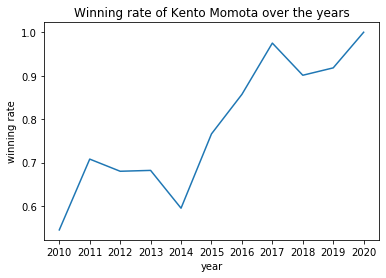

In [0]:
plt.plot(years, winRates, '-')
plt.title('Winning rate of Kento Momota over the years')
plt.ylabel('winning rate')
plt.xlabel('year')

As we can see, Momota's winning rate has improved in general over the years.
However, the value we're observing is a ratio, which means it can be deceiving.
For instance, for the year 2020 the winning rate is 1.0, which is quite suspicious. The reason behind this is of course the lack of statistics, since the year 2020 has just begun when this analysis takes place and therefore not a lot of matches has been played.
Let's justify this plot by figuring out how many matches has Momota played each year.

In [0]:
nMatches = []
for key, dfi in year_group:
  nMatch_i = len(dfi)
  print('year ', key, ' : ', nMatch_i, ' matches')
  nMatches.append(nMatch_i)

year  2010  :  11  matches
year  2011  :  24  matches
year  2012  :  25  matches
year  2013  :  44  matches
year  2014  :  37  matches
year  2015  :  47  matches
year  2016  :  14  matches
year  2017  :  40  matches
year  2018  :  71  matches
year  2019  :  73  matches
year  2020  :  3  matches


Text(0.5, 0, 'year')

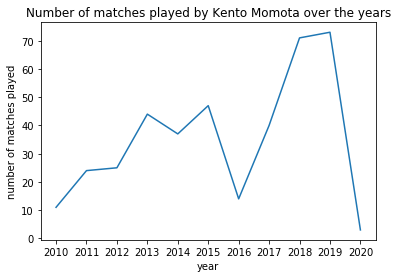

In [0]:
plt.plot(years, nMatches, '-')
plt.title('Number of matches played by Kento Momota over the years')
plt.ylabel('number of matches played')
plt.xlabel('year')

As expected, in year 2020 Momota has played only 3 matches, which explains the perfect winning rate. As a fresh men, it's understandable, that Momota only participated in 11 matches in year 2010 and as he gains more experience in adult matches, he has played more tournaments in the following years. The nosedive in year 2016 was caused by his suspension for visiting an illegal casino in japan for one year. Having played only 14 matches that year, the 0.857 winning rate is not particularly convincing. Nonetheless, we can say he was having a nice start of the year. 
In year 2017, after he went back from the suspension, we know that he won lots of gold medals and his world ranking rose from around 280 to 1 in about a year, which was incredible. The winning rate: 0.975 we have computed supports the above story. Although the number of matches he played in year 2017 was not comparable to those from the year 2018 and 2019, which makes the winning rate less convincing, 2017 was one of the dominating year he had. This makes it very intriguing to know what has actualy happend during his suspension.

Now let's take a look at Momota's opponents, in order to find out the candidates, who have the potential to produce great match with Momota and perhaps even turn into exciting rivals.
Before we start, let's first examin the opponent name category:

In [0]:
df.opponent.unique()

array(['KASHYAP PARUPALLI', 'H. S. PRANNOY', 'YU XIANG HUANG',
       'TZU WEI WANG', 'ANDERS ANTONSEN', 'JONATAN CHRISTIE',
       'ANTHONY SINISUKA GINTING', 'DAREN LIEW', 'ZII JIA LEE',
       'VIKTOR AXELSEN', 'RASMUS GEMKE', 'TIEN CHEN CHOU',
       'HANS-KRISTIAN SOLBERG VITTINGHUS', 'WING KI VINCENT WONG',
       'B. SAI PRANEETH', 'TOMMY SUGIARTO', 'LONG CHEN',
       'KUNLAVUT VITIDSARN', 'DONGHUN KIM', 'DAN LIN', 'KANTA TSUNEYAMA',
       'CAO CUONG PHAM', 'LUÍS ENRIQUE PEÑALVER', 'KANTAPHON WANGCHAROEN',
       'SITTHIKOM THAMMASIN', ' ZII JIA LEE', ' ANTHONY SINISUKA GINTING',
       ' YUQI SHI', 'DONG KEUN LEE', 'CHEUK YIU LEE', 'GUANGZU LU',
       'TIEN MINH NGUYEN', 'YUQI SHI', 'SRIKANTH KIDAMBI',
       'JAN O JORGENSEN', 'KHOSIT PHETPRADAB', 'KA LONG ANGUS NG',
       'BRICE LEVERDEZ', 'KENTA NISHIMOTO', 'SAMEER VERMA', ' WAN HO SON',
       'WAN HO SON', 'JEN HAO HSU', 'KAZUMASA SAKAI',
       ' SUPPANYU AVIHINGSANON', ' KHOSIT PHETPRADAB',
       ' SRIKANTH KIDAMBI'

Just as is the case in the location category (city and country), here we have some inconsistencies with how names are registered. For instance, ' LONG CHEN' and 'CHEN LONG' are clearly the same person. In this case, the first- and last-name are switched. One way to fix this, is to store the first- and last-name in a python set (or store them in an order following a specific rule), so that one can identify the player without needing to worry about the order of the names.

In [0]:
def fixName(x):
    while x[0] == ' ':
      x = x[1:]
    while x[-1] == ' ':
      x = x[:-1]  
    return ' '.join(sorted(x.split(' ')))

In [0]:
df['oppId'] = df.opponent.map(fixName)

Assuming there're no further typos in this category, we can try to find out how many matches has been played for each of Momota's opponents:

In [0]:
player_group = df.groupby('oppId')

In [0]:
nEncounters = player_group.size()
nEncounters

oppId
ABDUL ARIF LATIF MOHAMAD    1
ABIAN PABLO                 1
ADI KRISHNA NUGRAHA         1
ADULRACH NAMKUL             1
AKBAR PANJI SUDARJAT        1
                           ..
TAKUMA UEDA                 1
TZU WANG WEI                5
VATTANIRAPPEL VILSON        1
WANG ZHENGMING              5
ZULFADLI ZULKIFFLI          4
Length: 166, dtype: int64

Here are how many of the above matches has been won by Momota:

In [0]:
nWins = player_group.agg(np.sum)['won'].astype(int)
nWins

oppId
ABDUL ARIF LATIF MOHAMAD    0
ABIAN PABLO                 1
ADI KRISHNA NUGRAHA         1
ADULRACH NAMKUL             1
AKBAR PANJI SUDARJAT        1
                           ..
TAKUMA UEDA                 0
TZU WANG WEI                5
VATTANIRAPPEL VILSON        1
WANG ZHENGMING              2
ZULFADLI ZULKIFFLI          1
Name: won, Length: 166, dtype: int64

Let's focus on the players, who have played at least three matches with Momota, since conclusions drawn from little statistics are less significant. We print out the winning rate of Momota against these players to see which one of them made the most trouble for him.

In [0]:
atLeast3Times = nEncounters > 2

In [0]:
player_group.agg(np.sum)['won'].astype(int)[atLeast3Times] / player_group.size()[atLeast3Times]

oppId
ANDERS ANTONSEN                     0.833333
ANGUS KA LONG NG                    1.000000
ANTHONY GINTING SINISUKA            0.818182
AXELSEN VIKTOR                      0.866667
B. PRANEETH SAI                     0.714286
BIN QIAO                            0.000000
BOONSAK PONSANA                     0.750000
BRICE LEVERDEZ                      1.000000
CALJOUW MARK                        1.000000
CHEN CHOU TIEN                      0.846154
CHEN LONG                           0.555556
CHEUK LEE YIU                       1.000000
CHONG FENG WEI                      0.666667
CHONG LEE WEI                       0.500000
CHRISTIE JONATAN                    0.800000
DAN LIN                             0.800000
DAREN LIEW                          1.000000
GEMKE RASMUS                        1.000000
H. PRANNOY S.                       1.000000
HANS-KRISTIAN SOLBERG VITTINGHUS    1.000000
HANS-KRISTIAN VITTINGHUS            0.666667
HEE HEO KWANG                       1.000000
HO S

Here more spelling inconsistencies are spotted:
'HANS-KRISTIAN SOLBERG VITTINGHUS' -> 'HANS-KRISTIAN VITTINGHUS'
'K. SRIKANTH' -> 'KIDAMBI SRIKANTH'
Let's write a mapping to fix these:

In [0]:
#def nameMap(x):

nameMap = {'K. SRIKANTH': 'KIDAMBI SRIKANTH',
           'HANS-KRISTIAN SOLBERG VITTINGHUS': 'HANS-KRISTIAN VITTINGHUS'}

In [0]:
df.oppId = df.oppId.map(lambda x: nameMap[x] if x in nameMap else x)

Let's try it again:

In [0]:
player_group = df.groupby('oppId')
(player_group['won'].agg(np.sum).astype(int)[atLeast3Times] / player_group.size()[atLeast3Times]).sort_values()

oppId
BIN QIAO                    0.000000
ZULFADLI ZULKIFFLI          0.250000
WANG ZHENGMING              0.400000
CHONG LEE WEI               0.500000
CHEN LONG                   0.555556
MINH NGUYEN TIEN            0.600000
HO SON WAN                  0.625000
JAN JORGENSEN O             0.625000
HU YUN                      0.666667
SHI YUQI                    0.666667
CHONG FENG WEI              0.666667
KI VINCENT WING WONG        0.666667
SUGIARTO TOMMY              0.700000
B. PRANEETH SAI             0.714286
KENTA NISHIMOTO             0.750000
BOONSAK PONSANA             0.750000
SONG XUE                    0.750000
CHRISTIE JONATAN            0.800000
DAN LIN                     0.800000
KANTA TSUNEYAMA             0.800000
KIDAMBI SRIKANTH            0.800000
ANTHONY GINTING SINISUKA    0.818182
ANDERS ANTONSEN             0.833333
CHEN CHOU TIEN              0.846154
AXELSEN VIKTOR              0.866667
NAN WEI                     0.875000
HANS-KRISTIAN VITTINGHUS    0.88

In [0]:
df[df.oppId == 'BIN QIAO']

,Tournament,Duration,weekday,month,day,year,city,country,isPlayer1,opponent,nationality,gm1_plr1,gm1_plr2,gm2_plr1,gm2_plr2,gm3_plr1,gm3_plr2,in2Games,1GameWonByP1,2GameWonByP1,3GameWonByP1,wonByP1,won,oppId
316,Yonex Australian Badminton Open 2013,46,Thu,4,4,2013,sydney,Australia,False,BIN QIAO,CHN,21.0,19.0,21.0,18.0,NaN,NaN,True,True,True,False,True,False,BIN QIAO
318,YONEX German Open 2013,46,Wed,2,27,2013,mülheim an der ruhr,Germany,False,BIN QIAO,CHN,21.0,16.0,21.0,18.0,NaN,NaN,True,True,True,False,True,False,BIN QIAO
345,Li Ning China Masters 2012,41,Tue,9,11,2012,changzhou,China,True,BIN QIAO,CHN,13.0,21.0,17.0,21.0,NaN,NaN,True,False,False,False,False,False,BIN QIAO


While there're lots of players, who didn't manage to win even once against Momota (winning rate = 1.0), BIN QIAO keeps his 100% winning rate (winning rate = 0.0) against Momota after playing at least three matches with him. However this player is already retired and these events took place in 2012 ~ 2013, which are long before Momota's wonder years (from 2017). This reminds us to also keep track of the time. That is, observing the trend of Momota's winning rate against his major opponents. 

In [0]:
# Call players, who have played at least three matches with Momota, Momota's major opponents. Here's the list storing the oppId of the player names.
majorOpps = list(player_group.size()[atLeast3Times].index)

In [0]:
# Filter the dataframe according to the above list.
df_majorOpps = df[df.oppId.isin(majorOpps)]
majorOpp_group = df_majorOpps.groupby(['oppId','year'])

In [0]:
plr_yr_wr = majorOpp_group['won'].agg(np.sum).astype(int) / majorOpp_group.size()
plr_yr_wr

oppId               year
ANDERS ANTONSEN     2018    1.000000
                    2019    0.666667
ANGUS KA LONG NG    2011    1.000000
                    2015    1.000000
                    2016    1.000000
                              ...   
WANG ZHENGMING      2014    0.333333
                    2015    1.000000
ZULFADLI ZULKIFFLI  2010    0.000000
                    2011    0.000000
                    2016    1.000000
Length: 126, dtype: float64

Some of the players have no registrated matches against Momota afer a specific year (because of say retirement). Let's filter them out first.

In [0]:
majorOpps = list(df_majorOpps.groupby('oppId').year.agg(np.max).astype(int).loc[lambda x: x>2016].index)

In [0]:
df_majorOpps = df[df.oppId.isin(majorOpps)]
majorOpp_group = df_majorOpps.groupby(['oppId','year'])

We can then store these (years, scores) list pairs for each players into a dictionary and plot them:

In [0]:
win_rates = {plr: [[],[]] for plr in majorOpps}

for key, dfi in majorOpp_group:
    plr = key[0] # player's oppId
    yr = key[1] # year of match
    win_rates[plr][0].append(yr)
    wr = dfi.won.agg(np.sum).astype(int) / len(dfi) # winning rate
    win_rates[plr][1].append(wr)

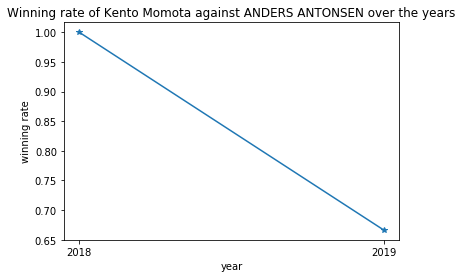

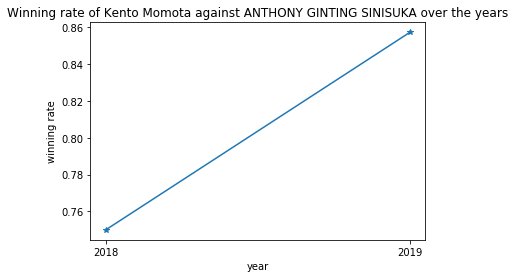

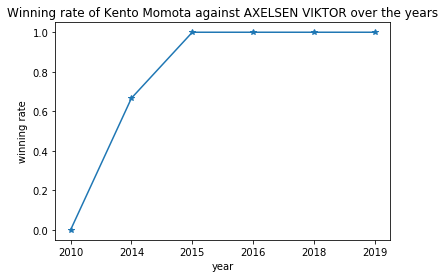

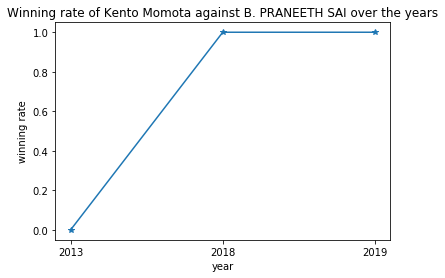

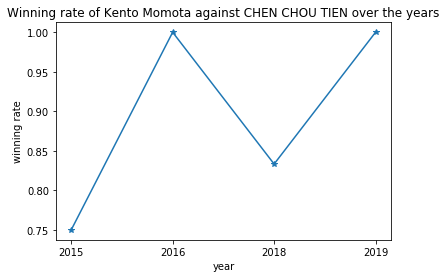

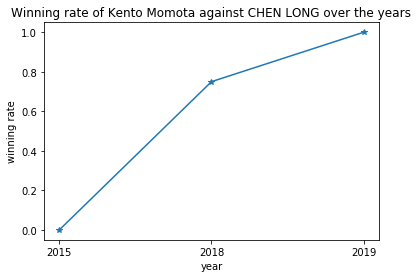

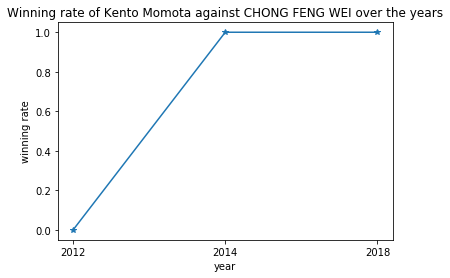

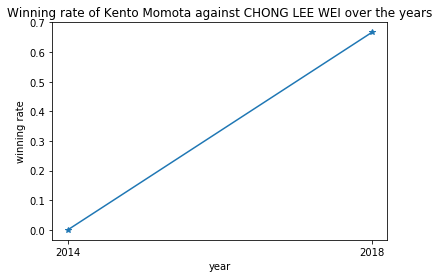

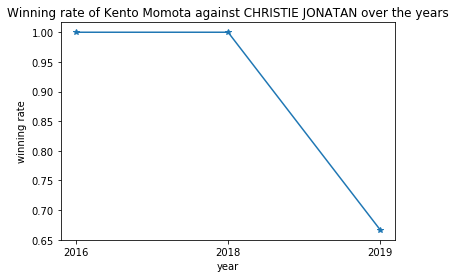

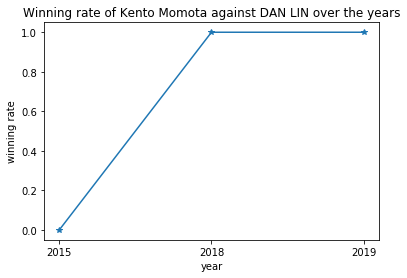

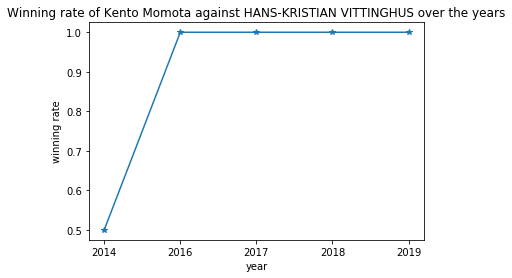

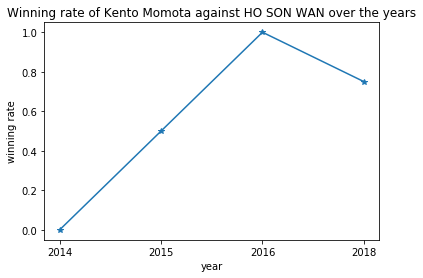

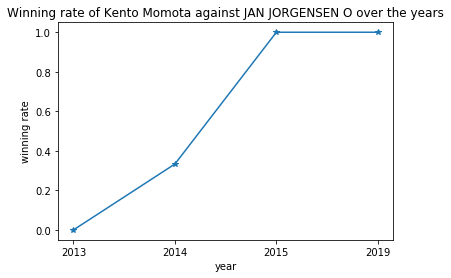

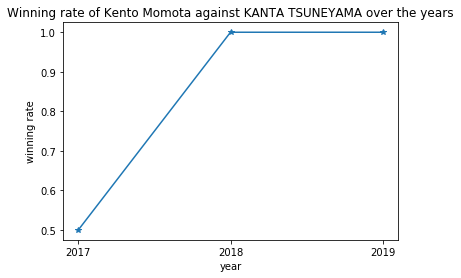

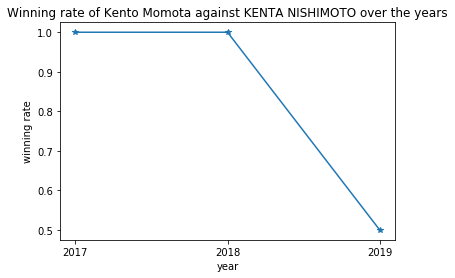

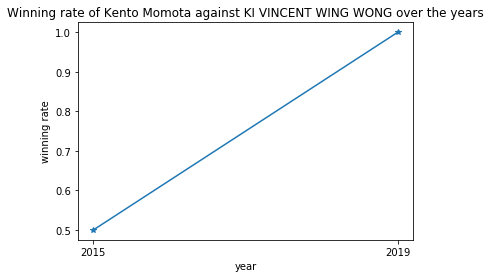

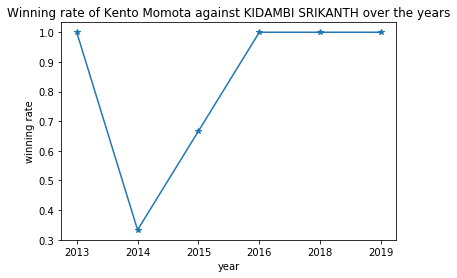

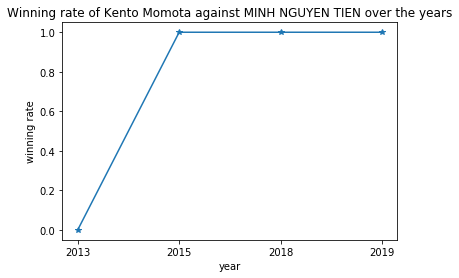

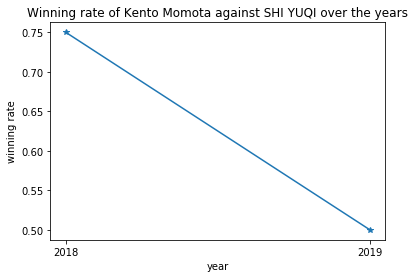

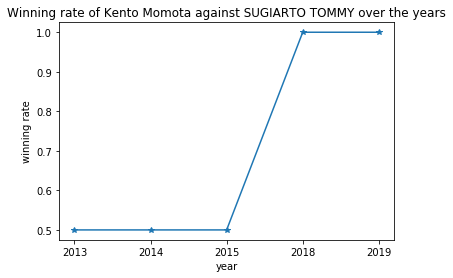

In [0]:
for plr in majorOpps:
    # There are many players, who have no winning record against Momota.
    # We don't want to discard them as major opponents, but there's no need to plot them here.
    if np.mean(win_rates[plr][1]) == 1:
        continue
    plt.plot(win_rates[plr][0], win_rates[plr][1], '*-')
    plt.title('Winning rate of Kento Momota against ' + plr + ' over the years')
    plt.ylabel('winning rate')
    plt.xlabel('year')
    plt.show()
    plt.close()

Just from these plots we learned that the following players have some improvement in terms of winning against Momota:
ANDERS ANTONSEN,
CHRISTIE JONATAN,
HO SON WAN,
KENTA NISHIMOTO,
SHI YUQI

Although the head to head records can reflect in a way, whether the players are potentially a threat to Momota, this is not the whole picture. Sometimes a match was won by Momota, but the progress was not at all straight forward for him. After all, not being able to win a match doesn't simply means not being a trouble for Momota. The players, who manage to cause trouble to him may win against him in the future. Let's come up with a score, which can relect how difficult it was for Momota to score points.
One of the ideas is to compute the ratio between the score won and lost by Momota. So just by looking at this score, one knows how many points he can win before he looses one point on average.
Another idea is to compute the mean time needed for Momota to score points.
Let realize them one at a time:

In [0]:
df_majorOpps['plr1score'] = df_majorOpps.gm1_plr1 + df_majorOpps.gm2_plr1 + df_majorOpps.gm3_plr1.fillna(0)
df_majorOpps['plr2score'] = df_majorOpps.gm1_plr2 + df_majorOpps.gm2_plr2 + df_majorOpps.gm3_plr2.fillna(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
def winLossRate(row):
    if row['isPlayer1']:
        return row['plr1score'] / float(row['plr2score'])
    else:
        return row['plr2score'] / float(row['plr1score'])

If one just want to know how a player performed in a specific year, it's computationally cheaper to do the division when the aggregation operation is applied to the dataframe. Since this is also a good metric to indicate how easy it was for Momota to score in a particular match, it does no harm to store them for each event.

In [0]:
df_majorOpps['win_loss_rate'] = df_majorOpps.apply(winLossRate, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
majorOpp_group = df_majorOpps.groupby(['oppId','year'])

In [0]:
win_loss_rates = {plr: [[],[]] for plr in majorOpps}

for key, dfi in majorOpp_group:
    plr = key[0] # player's oppId
    yr = key[1] # year of match
    win_loss_rates[plr][0].append(yr)
    wlr = dfi.win_loss_rate.agg(np.mean) # winning rate
    win_loss_rates[plr][1].append(wlr)

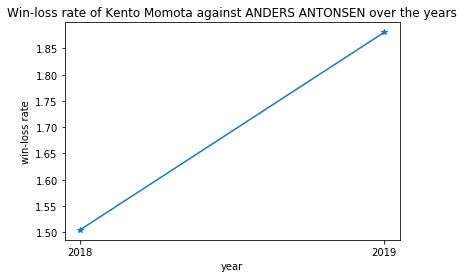

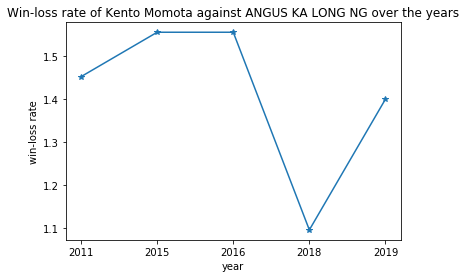

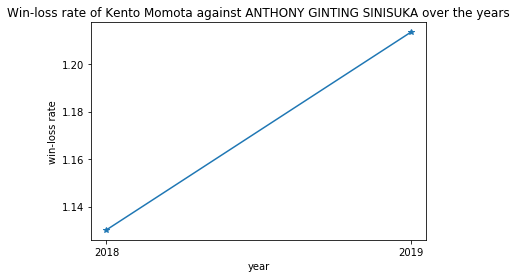

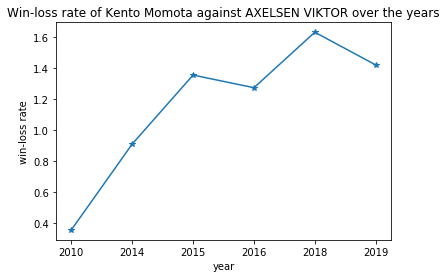

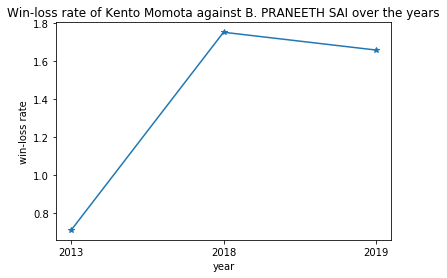

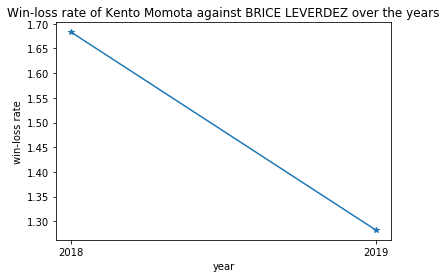

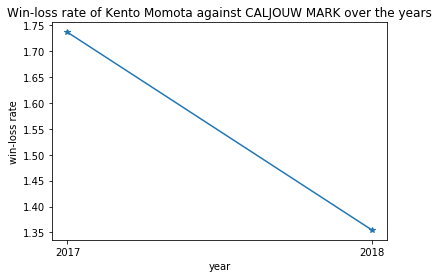

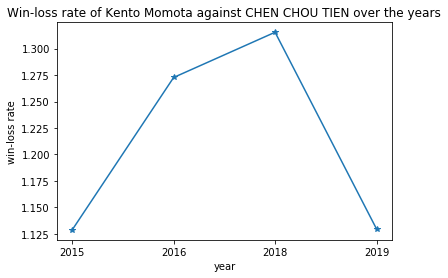

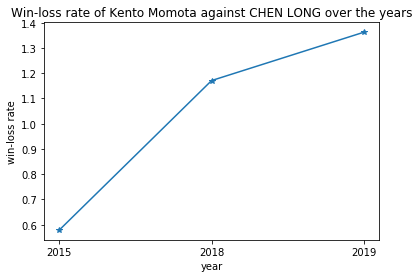

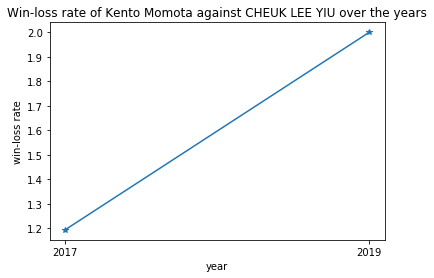

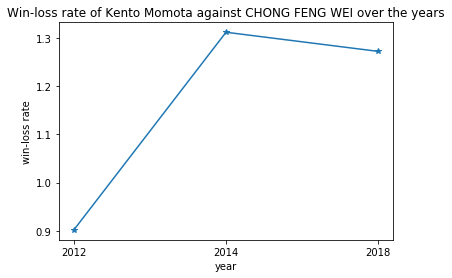

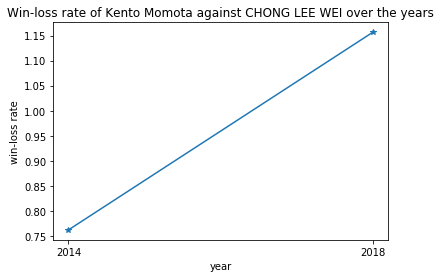

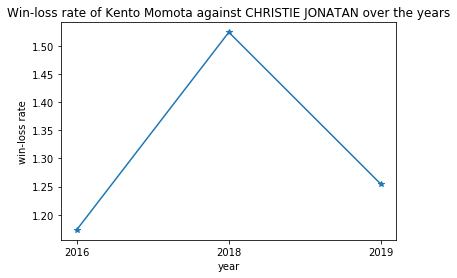

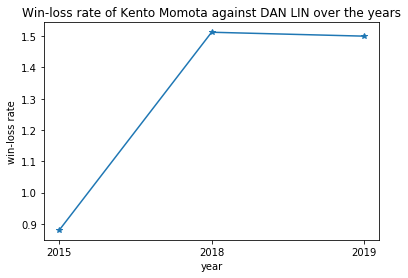

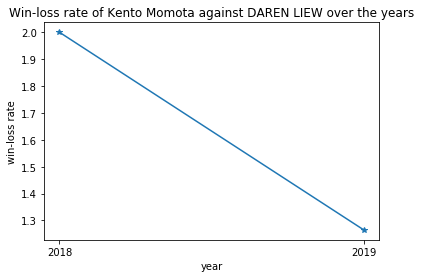

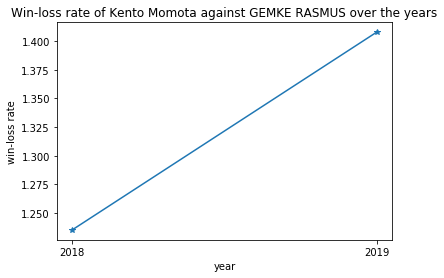

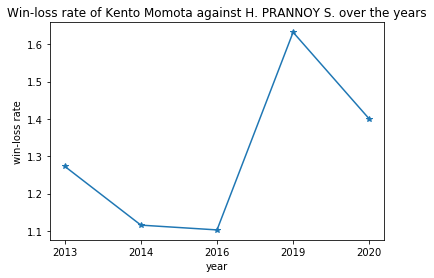

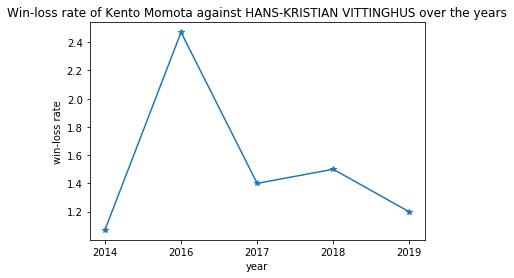

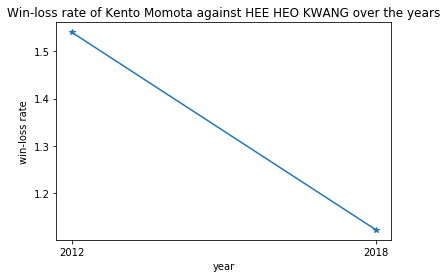

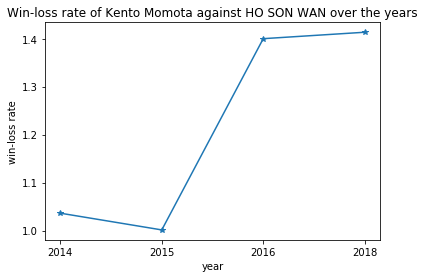

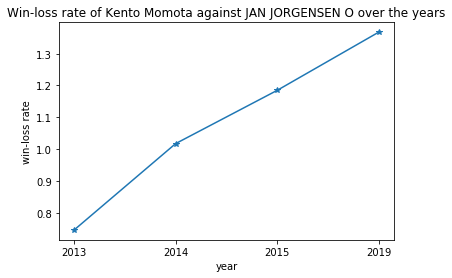

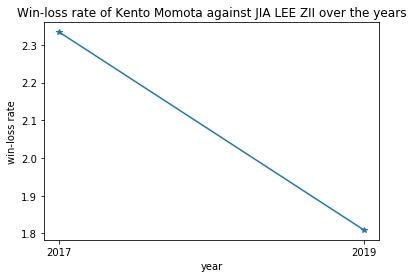

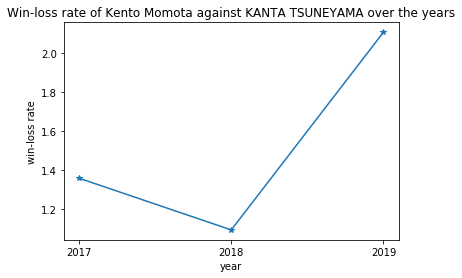

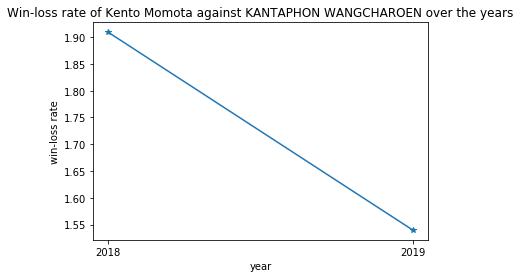

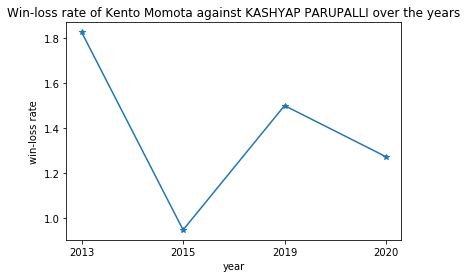

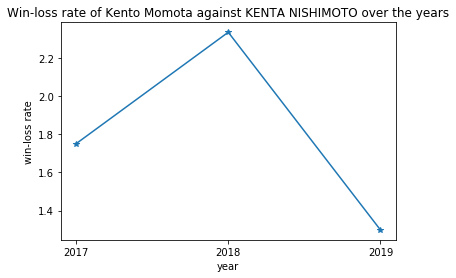

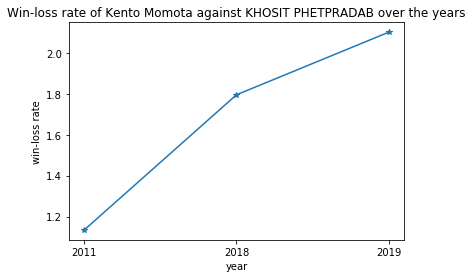

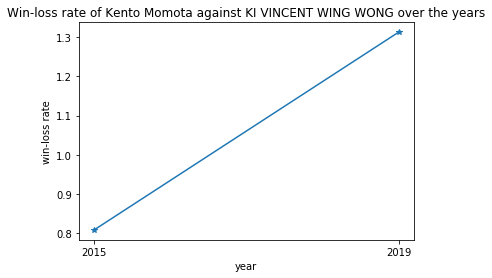

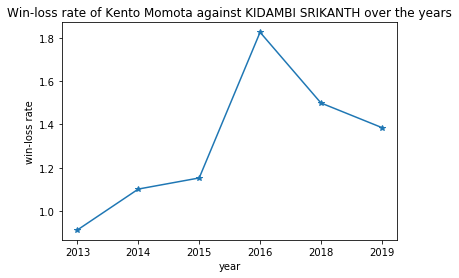

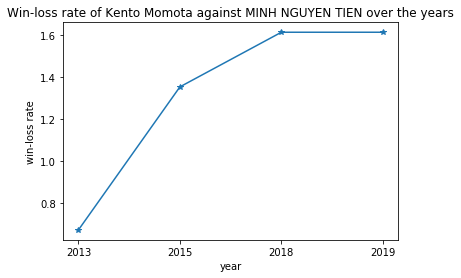

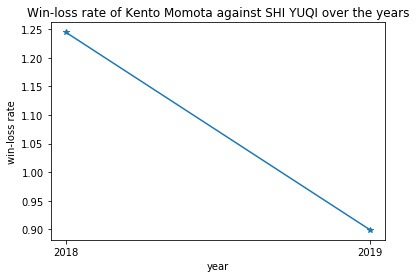

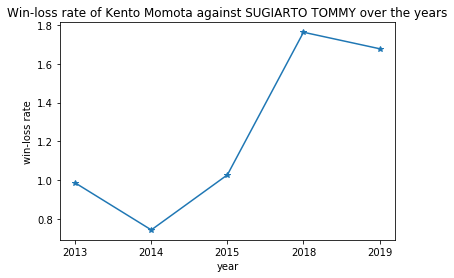

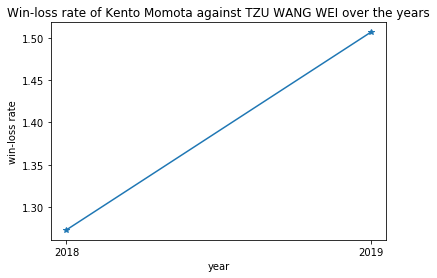

In [0]:
for plr in majorOpps:
    plt.plot(win_loss_rates[plr][0], win_loss_rates[plr][1], '*-')
    plt.title('Win-loss rate of Kento Momota against ' + plr + ' over the years')
    plt.ylabel('win-loss rate')
    plt.xlabel('year')
    plt.show()
    plt.close()

One interesting fact we can find out is that SHI YUQI is the only player, who has below 1.0 win-loss rate against Momota. Although SHI is now loosing in the head to head department (as shown below), he is actually scoring more points on average than Momota in their encounters.

In [0]:
df_SHI = df_majorOpps[df_majorOpps.oppId == 'SHI YUQI']

In [0]:
print('Head to head of SHI YUQI vs. Kento Momota: ', len(df_SHI)-df_SHI.won.sum(),':', df_SHI.won.sum())

Head to head of SHI YUQI vs. Kento Momota:  2 : 4


Let's take a closer look at their encounters:

In [0]:
time_SHI = (df_SHI.year.astype(str) + '_' + df_SHI.month.astype(str)).to_list()[::-1]
wlr_SHI = df_SHI.win_loss_rate.to_list()[::-1]

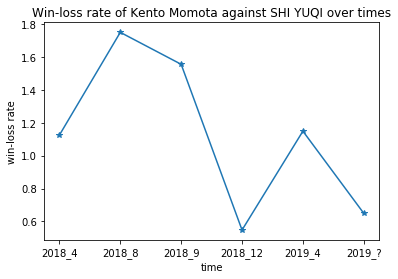

In [0]:
plt.plot(time_SHI, wlr_SHI, '*-')
plt.title('Win-loss rate of Kento Momota against ' + 'SHI YUQI' + ' over times')
plt.ylabel('win-loss rate')
plt.xlabel('time')
plt.show()
plt.close()

The reason SHI managed to have a better win-loss rate against Momota is that he won 2 of the 3 recent encounters. Let's print out the win-loss rate of these events:

In [0]:
wlr_SHI[-3:]

[0.5476190476190477, 1.148936170212766, 0.6491228070175439]

First of all, 1.15 means that having won the match Momota didn't won it with ease:

In [0]:
print('SHI scored on average ', int(21 / 1.15), ' points in a game.')

SHI scored on average  18  points in a game.


This means in tha match, SHI only lost 3 points per game on average. 
What about the two matches, in which SHI has won?

In [0]:
print('Momota scored on average ', int(21 * (0.55+0.65)/2), ' points in a game.')

Momota scored on average  12  in a game.


This means Momota only scored around half of the points there were to score in a game on average. In badminton terms, this is a big margin. This is very interesting, since just three month before SHI started the first win against Momota, the win-loss rate for Momota was pretty high. So maybe SHI or his coach team found out a weakness of Momota during that period? The sad news is SHI had an injury in a recent match, so we might not see a SHI vs. Momota rivalry in a moment.

Another player worth mentioning is CHEN CHOU TIEN:

In [0]:
df_CHOU = df_majorOpps[df_majorOpps.oppId == 'CHEN CHOU TIEN']

In [0]:
print('Head to head of CHEN CHOU TIEN vs. Kento Momota: ', len(df_CHOU)-df_CHOU.won.sum(),':', df_CHOU.won.sum())

Head to head of CHEN CHOU TIEN vs. Kento Momota:  2 : 11


In [0]:
time_CHOU = (df_CHOU.year.astype(str) + '_' + df_CHOU.month.astype(str)).to_list()[::-1]
wlr_CHOU = df_CHOU.win_loss_rate.to_list()[::-1]

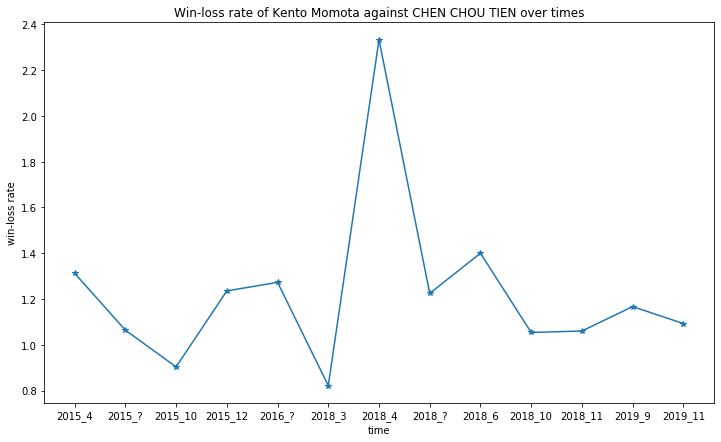

In [0]:
fig = plt.gcf()
fig.set_size_inches(12, 7)
plt.plot(time_CHOU, wlr_CHOU, '*-')
plt.title('Win-loss rate of Kento Momota against ' + 'CHEN CHOU TIEN' + ' over times')
plt.ylabel('win-loss rate')
plt.xlabel('time')
plt.show()
plt.close()

In [0]:
print('Average win-loss rate of CHOU in the recent 4 encounters with Momota: ', np.mean(wlr_CHOU[-4:]))

Average win-loss rate of CHOU in the recent 4 encounters with Momota:  1.093207671957672


In [0]:
print('Despite losing all of them, CHOU managed to score on average ', int(21 / 1.09), ' points in a game.')
print('In other words, he has lost only ', 21-int(21 / 1.09), ' points in a game on average. Which is the smallest margin required to win a game.')

Despite losing all of them, CHOU managed to score on average  19  points in a game.
In other words, he has lost only  2  points in a game on average. Which is the smallest margin required to win a game.


So it was not easy at all for Momota to win this player. Maybe all it takes for CHOU to win is a bit of luck next time. Regardless, we expect a close match the next time these two players encounter. 

Similar to CHOU, HANS-KRISTIAN VITTINGHUS is an opponent not to be ignored by Momota:

In [0]:
df_HANS = df_majorOpps[df_majorOpps.oppId == 'HANS-KRISTIAN VITTINGHUS']

In [0]:
print('Head to head of HANS-KRISTIAN VITTINGHUS vs. Kento Momota: ', len(df_HANS)-df_HANS.won.sum(),':', df_HANS.won.sum())

Head to head of HANS-KRISTIAN VITTINGHUS vs. Kento Momota:  1 : 8


In [0]:
time_HANS = (df_HANS.year.astype(str) + '_' + df_HANS.month.astype(str)).to_list()[::-1]
wlr_HANS = df_HANS.win_loss_rate.to_list()[::-1]

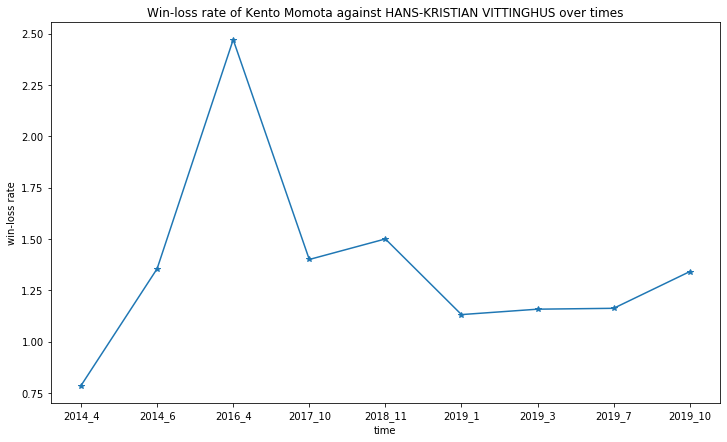

In [0]:
fig = plt.gcf()
fig.set_size_inches(12, 7)
plt.plot(time_HANS, wlr_HANS, '*-')
plt.title('Win-loss rate of Kento Momota against ' + 'HANS-KRISTIAN VITTINGHUS' + ' over times')
plt.ylabel('win-loss rate')
plt.xlabel('time')
plt.show()
plt.close()

In [0]:
print('Average win-loss rate of HANS in the recent 4 encounters with Momota: ', np.mean(wlr_HANS[-4:]))

Average win-loss rate of HANS in the recent 4 encounters with Momota:  1.198136234320445


In [0]:
print('Also, despite losing all of them, HANS managed to score on average ', int(21 / 1.20), ' points in a game.')
print('In other words, he has lost only ', 21-int(21 / 1.20), ' points in a game on average. Which is not a large margin.')

Also, despite losing all of them, HANS managed to score on average  17  points in a game.
In other words, he has lost only  4  points in a game on average. Which is not a large margin.


Let's not forget to take a look at ANTHONY GINTING SINISUKA, who is said to be the biggest enemy of Momota by the fans and media:

Head to head of ANTHONY GINTING SINISUKA vs. Kento Momota:  2 : 9


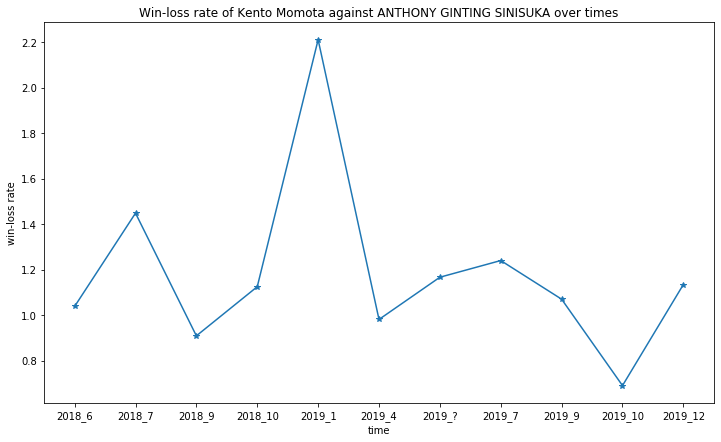

Average win-loss rate of GINTING in the recent 4 encounters with Momota:  1.0338167534220166
Despite losing most of them, GINTING managed to score on average  20  points in a game.
In other words, he has lost only  1  points in a game on average, which is almost as close as it can get.
Not to mention, that ginting has won 1 out of the recent 4 encounters.
This separate GINTING from CHOU and HANS, who did not manage to win a match in the recent encounters.


In [0]:
df_GINTING = df_majorOpps[df_majorOpps.oppId == 'ANTHONY GINTING SINISUKA']

print('Head to head of ANTHONY GINTING SINISUKA vs. Kento Momota: ', len(df_GINTING)-df_GINTING.won.sum(),':', df_GINTING.won.sum())

time_GINTING = (df_GINTING.year.astype(str) + '_' + df_GINTING.month.astype(str)).to_list()[::-1]
wlr_GINTING = df_GINTING.win_loss_rate.to_list()[::-1]

fig = plt.gcf()
fig.set_size_inches(12, 7)
plt.plot(time_GINTING, wlr_GINTING, '*-')
plt.title('Win-loss rate of Kento Momota against ' + 'ANTHONY GINTING SINISUKA' + ' over times')
plt.ylabel('win-loss rate')
plt.xlabel('time')
plt.show()
plt.close()

print('Average win-loss rate of GINTING in the recent 4 encounters with Momota: ', np.mean(wlr_GINTING[-4:]))

print('Despite losing most of them, GINTING managed to score on average ', int(21 / 1.03), ' points in a game.')
print('In other words, he has lost only ', 21-int(21 / 1.03), ' points in a game on average, which is almost as close as it can get.')
print('Not to mention, that ginting has won ' + str((~df_GINTING.won.iloc[-4:]).sum()) + ' out of the recent 4 encounters.')
print('This separate GINTING from CHOU and HANS, who did not manage to win a match in the recent encounters.')

So we can confirm that the fans and media have a point. Despite losing by a large margin in the head to head part, they had close games in terms of scoring points. This explains why people are excited when these two players confronting each other.

Before we move on to the next metric, let's plot the histogram of win-loss rate against the major opponents in Momota's career, which could be compared with other great badminton players in the future analysis:

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 5., 11., 20., 36., 42., 31., 20., 14., 10.,  5.,  5.,  1.,  0.,
         0.,  0.,  1.]),
 array([0.35714286, 0.55357143, 0.75      , 0.94642857, 1.14285714,
        1.33928571, 1.53571429, 1.73214286, 1.92857143, 2.125     ,
        2.32142857, 2.51785714, 2.71428571, 2.91071429, 3.10714286,
        3.30357143, 3.5       ]),
 <a list of 16 Patch objects>)

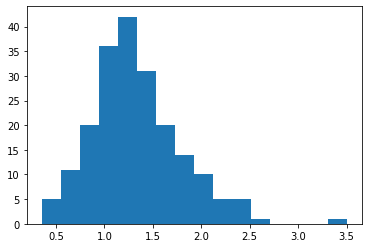

In [0]:
plt.hist(bins = 16, x = df_majorOpps.win_loss_rate)

In [0]:
from functools import reduce

reduce(lambda x, y: x/2.+y, [1,2,3,4]) 

6.125